In [18]:
!pip install torch_geometric

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## CORA Dataset Overview

The CORA dataset is a commonly used benchmark dataset in the field of machine learning, especially for graph neural networks and node classification tasks. It consists of a citation network of scientific publications.

**Nodes:** Each node in the graph represents a scientific paper. There are 2,708 nodes in the CORA dataset.

**Edges:** An edge between two nodes indicates that one paper cites the other. There are 5,429 edges in the dataset.

**Features:** Each node has a 1,433-dimensional feature vector. This vector is a sparse representation of the words in the paper's abstract, indicating which words are present in the abstract.

**Labels:** Each node is labeled with one of 7 classes, representing the category of the paper:
*   Case-Based
*   Genetic Algorithms
*   Neural Networks
*   Probabilistic Methods
*   Reinforcement Learning
*   Rule Learning
*   Theory

In [6]:
# Load only one graph
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Visualize it via Networkx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=30, node_color=data.y, cmap='cool')
plt.title('CORA Dataset Graph')
plt.show()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
# Extract features, adjacency matrix, and labels
features = data.x.numpy()
labels = data.y.numpy()
edge_index = data.edge_index.numpy()

# Print feature matrix and labels for the first 5 nodes
print("Feature matrix (first 5 nodes):")
print(features[:5])
print("\nLabels (first 5 nodes):")
print(labels[:5])

Feature matrix (first 5 nodes):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Labels (first 5 nodes):
[3 4 4 0 3]


In [9]:
# Create adjacency matrix from edge_index
num_nodes = features.shape[0]

# - A: Adjacency matrix initialized to zeros
A = np.zeros((num_nodes, num_nodes))
# - zip(edge_index[0], edge_index[1]): Pairs of edges
for i, j in zip(edge_index[0], edge_index[1]):
    # - A[i, j] = 1: Setting the adjacency matrix entries to 1 where there is an edge
    A[i, j] = 1

# Add self-loops with I: Identity matrix for adding self-loops
I = np.eye(num_nodes)
A_hat = A + I

print(A_hat)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


GRAPH CONVOLUTIONAL NETWORKS (GCN) - ICLR 2017

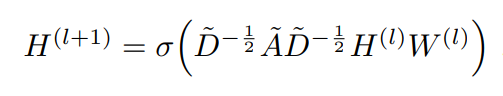

In [10]:
# Define the Graph Convolutional Layer without normalization
class GraphConvolutionLayer:
    def __init__(self, input_dim, output_dim):
        # Initializes the weight matrix W with small random values
        self.W = np.random.randn(input_dim, output_dim) * 0.01

    def forward(self, A, X):
        # Performs the forward pass (aggregation and transformation)
        return A @ X @ self.W

    def backward(self, A, X, grad_output):
        # Computes gradients for the input features and weights
        grad_input = A @ grad_output @ self.W.T
        grad_W = X.T @ (A @ grad_output)
        return grad_input, grad_W

In [42]:
# Define the GCN model
class GCN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # two layers
        self.gcn1 = GraphConvolutionLayer(input_dim, hidden_dim)
        self.gcn2 = GraphConvolutionLayer(hidden_dim, output_dim)

    def forward(self, A, X):
        # Performs the forward pass through the layers
        H = self.gcn1.forward(A, X)
        # ReLU activation
        H = np.maximum(H, 0)
        H = self.gcn2.forward(A, H)
        # no ReLU activation
        return H

    def backward(self, A, X, grad_output):
        # Backpropagation
        grad_output, grad_W2 = self.gcn2.backward(A, self.gcn1.forward(A, X), grad_output)
        grad_output = np.where(self.gcn1.forward(A, X) > 0, grad_output, 0)  # ReLU gradient
        _, grad_W1 = self.gcn1.backward(A, X, grad_output)
        return grad_W1, grad_W2

    def predict(self, A, X):
        # Prediction
        H = self.forward(A, X)
        return np.argmax(H, axis=1)

In [43]:
# Training parameters
input_dim = features.shape[1]
hidden_dim = 16
output_dim = len(set(labels))
learning_rate = 0.001
epochs = 50

gcn_model = GCN(input_dim, hidden_dim, output_dim)
labels_one_hot = np.eye(output_dim)[labels]
losses = []

print("Parameters")
print("input_dim:", input_dim)
print("hidden_dim:", hidden_dim)
print("output_dim:", output_dim)
print("learning_rate:", learning_rate)
print("epochs:", epochs)
print("labels", labels_one_hot.shape)
for i in range(5):
    print(labels_one_hot[i])

Parameters
input_dim: 1433
hidden_dim: 16
output_dim: 7
learning_rate: 0.001
epochs: 50
labels (2708, 7)
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]


In [44]:
# One iteration of the training loop
H = gcn_model.forward(A_hat, features)
print("Model output", H.shape)
for i in range(5):
    print(H[i])
# Loss here is mean squared error (MSE)
loss = np.mean((H - labels_one_hot) ** 2)
print("Labels", labels_one_hot.shape)
for i in range(5):
    print(labels_one_hot[i])
print("Loss", loss)

Model output (2708, 7)
[-0.00493877 -0.00980743  0.00692941 -0.00459775  0.00624501 -0.01054938
 -0.00756141]
[ 0.00158775  0.00620117  0.00667747 -0.00587986  0.01460105  0.00028892
  0.00469541]
[-1.76156062e-03  5.40961740e-03  2.16976029e-02  2.20949949e-05
  1.24754296e-02 -3.72340177e-03  6.51131006e-03]
[-2.75082916e-05  1.42334052e-03 -8.73610348e-04 -1.15504109e-03
 -1.73691809e-03 -6.39095800e-04  1.45165053e-03]
[-0.01467372 -0.0279487   0.01244069  0.01223288  0.00409554 -0.01373595
 -0.01345229]
Labels (2708, 7)
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
Loss 0.14306225908084824


In [45]:
# Compute gradients
grad_output = 2 * (H - labels_one_hot) / H.shape[0]
print("Gradient", grad_output.shape)
for i in range(5):
    print(grad_output[i])
grad_W1, grad_W2 = gcn_model.backward(A_hat, features, grad_output)
gcn_model.gcn1.W -= learning_rate * grad_W1
gcn_model.gcn2.W -= learning_rate * grad_W2
print("Updated W1", gcn_model.gcn1.W.shape)
print("Updated W2", gcn_model.gcn2.W.shape)
print(f'Loss: {loss}')

Gradient (2708, 7)
[-3.64753825e-06 -7.24330402e-06  5.11772997e-06 -7.41948113e-04
  4.61226405e-06 -7.79127163e-06 -5.58449501e-06]
[ 1.17264018e-06  4.57988956e-06  4.93165851e-06 -4.34258446e-06
 -7.27768798e-04  2.13379657e-07  3.46780444e-06]
[-1.30100489e-06  3.99528612e-06  1.60248175e-05  1.63183124e-08
 -7.29338678e-04 -2.74992745e-06  4.80894391e-06]
[-7.38572754e-04  1.05121161e-06 -6.45207052e-07 -8.53058413e-07
 -1.28280509e-06 -4.72005761e-07  1.07212004e-06]
[-1.08373105e-05 -2.06415791e-05  9.18810091e-06 -7.29517815e-04
  3.02476987e-06 -1.01447170e-05 -9.93522157e-06]
Updated W1 (1433, 16)
Updated W2 (16, 7)
Loss: 0.14306225908084824


In [50]:
# Training in full
gcn_model = GCN(input_dim, hidden_dim, output_dim)
losses = []
accs = []

for epoch in range(epochs):
    H = gcn_model.forward(A_hat, features)
    loss = np.mean((H - labels_one_hot) ** 2)
    losses.append(loss)
    grad_output = 2 * (H - labels_one_hot) / H.shape[0]
    grad_W1, grad_W2 = gcn_model.backward(A_hat, features, grad_output)
    gcn_model.gcn1.W -= learning_rate * grad_W1
    gcn_model.gcn2.W -= learning_rate * grad_W2
    # Evaluation
    predictions = gcn_model.predict(A_hat, features)
    accuracy = np.mean(predictions == labels)
    accs.append(accuracy)
    print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy:.4f}')

Epoch 0, Loss: 0.1453725740086603, Accuracy: 0.1178
Epoch 1, Loss: 0.14465181840079505, Accuracy: 0.1237
Epoch 2, Loss: 0.14402311370884102, Accuracy: 0.1267
Epoch 3, Loss: 0.1435028633817683, Accuracy: 0.1292
Epoch 4, Loss: 0.14302119371223715, Accuracy: 0.1300
Epoch 5, Loss: 0.1425678887931412, Accuracy: 0.1329
Epoch 6, Loss: 0.14213605924241762, Accuracy: 0.1366
Epoch 7, Loss: 0.14172241187035486, Accuracy: 0.1385
Epoch 8, Loss: 0.14132399375880658, Accuracy: 0.1396
Epoch 9, Loss: 0.14094179731095838, Accuracy: 0.1418
Epoch 10, Loss: 0.14057119943113458, Accuracy: 0.1444
Epoch 11, Loss: 0.14020614891657251, Accuracy: 0.1444
Epoch 12, Loss: 0.1398484977010476, Accuracy: 0.1448
Epoch 13, Loss: 0.13949046606871918, Accuracy: 0.1459
Epoch 14, Loss: 0.13913251574931068, Accuracy: 0.1466
Epoch 15, Loss: 0.13877397121943708, Accuracy: 0.1470
Epoch 16, Loss: 0.13841515335755947, Accuracy: 0.1488
Epoch 17, Loss: 0.13805670790639663, Accuracy: 0.1525
Epoch 18, Loss: 0.13769752662491133, Accur

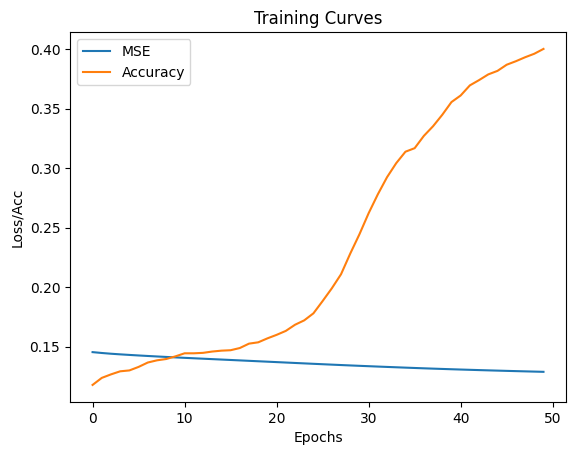

In [53]:
# Plotting the loss curve
plt.plot(losses, label='MSE')
plt.plot(accs, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.title('Training Curves')
plt.legend()
plt.show()

In [71]:
# Training with PyTorch Geometric's built-in GCN layer
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the GCN model using PyG
class PyG_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(PyG_GCN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Set parameters
num_layers = 2
epochs = 30
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = dataset.num_classes
model = PyG_GCN(input_dim, hidden_dim, output_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

# Training loop
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    # Evaluation
    _, pred = out.max(dim=1)
    correct = float(pred.eq(data.y).sum().item())
    accuracy = correct / len(data.y)

    print(f'Epoch {epoch}, Loss with PyG: {loss.item()}, Accuracy: {accuracy:.4f}')

Total number of parameters: 23063
Epoch 0, Loss with PyG: 1.9476895332336426, Accuracy: 0.1366
Epoch 1, Loss with PyG: 1.9353762865066528, Accuracy: 0.1953
Epoch 2, Loss with PyG: 1.9230340719223022, Accuracy: 0.2555
Epoch 3, Loss with PyG: 1.9104409217834473, Accuracy: 0.3080
Epoch 4, Loss with PyG: 1.8976850509643555, Accuracy: 0.3246
Epoch 5, Loss with PyG: 1.8846632242202759, Accuracy: 0.3301
Epoch 6, Loss with PyG: 1.8715102672576904, Accuracy: 0.3264
Epoch 7, Loss with PyG: 1.8582428693771362, Accuracy: 0.3298
Epoch 8, Loss with PyG: 1.8448522090911865, Accuracy: 0.3257
Epoch 9, Loss with PyG: 1.8314015865325928, Accuracy: 0.3253
Epoch 10, Loss with PyG: 1.8177553415298462, Accuracy: 0.3205
Epoch 11, Loss with PyG: 1.8039796352386475, Accuracy: 0.3202
Epoch 12, Loss with PyG: 1.789987325668335, Accuracy: 0.3191
Epoch 13, Loss with PyG: 1.7758666276931763, Accuracy: 0.3183
Epoch 14, Loss with PyG: 1.7616238594055176, Accuracy: 0.3202
Epoch 15, Loss with PyG: 1.747249960899353, Acc

### Exercise

1. In the PyG implementation, we only use two layers. Try to add more and run the model. What is the effect of adding more layers?

2. We also only use a hidden dimension of 16. Try to add more and run the model. What is the effect of adding more layers?

3. Keep note of the number of parameters in the model. Within a 50,000 parameter budget, try to achieve the highest accuracy by changing the hidden dimension and layer count.